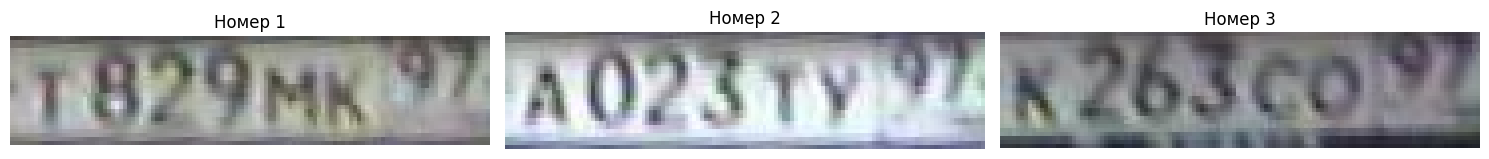

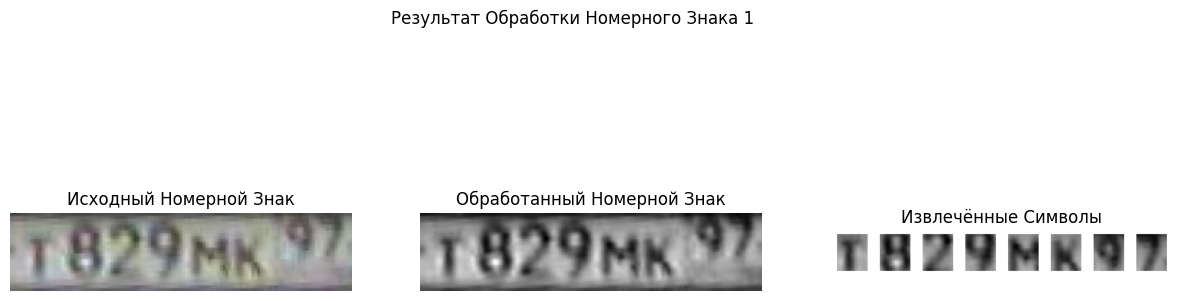

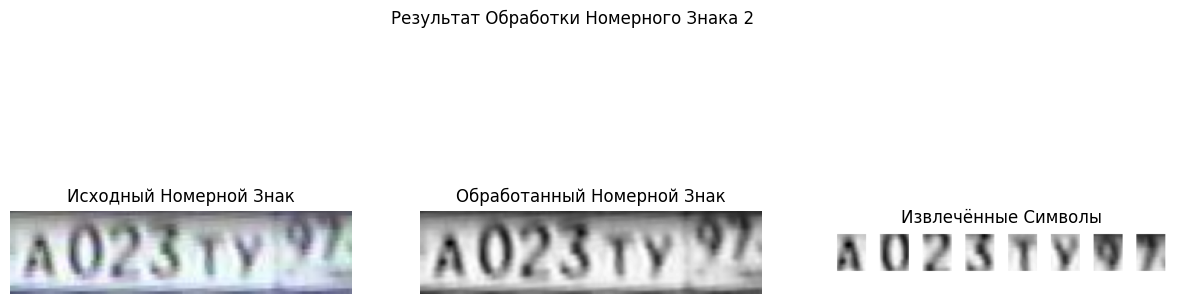

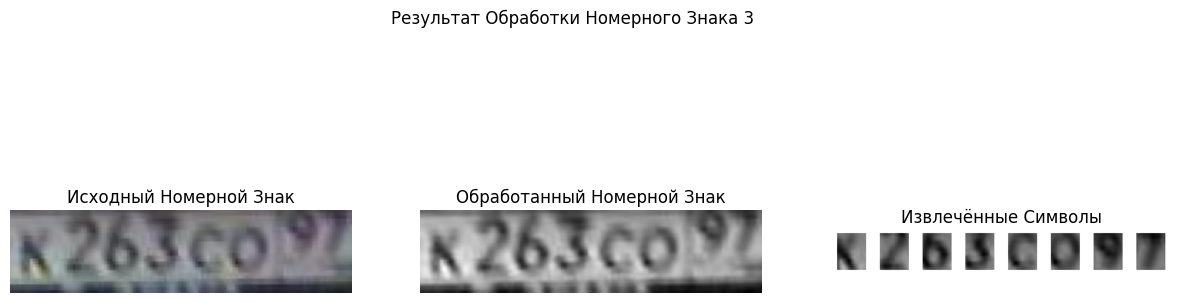

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageOps

# 1. Функция для упорядочивания точек
def order_points(pts):
    """
    Упорядочивает точки в порядке:
    верхний левый, верхний правый, нижний правый, нижний левый
    """
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] 
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] 
    rect[3] = pts[np.argmax(diff)] 

    return rect

# 2. Функция для перспективного преобразования
def get_transform(image, pts, padding=0.1):
    """
    Применяет перспективное преобразование к области, определенной точками pts в изображении.
    Уменьшает область захвата на заданный процент (padding).
    Возвращает обрезанное и преобразованное изображение номерного знака.
    
    :param image: Исходное изображение
    :param pts: Точки контура номерного знака (4 точки)
    :param padding: Процент уменьшения области захвата (например, 0.1 для 10%)
    """
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    center = np.mean(rect, axis=0)

    vectors = rect - center

    rect_shrinked = rect - vectors * padding

    rect_shrinked[:, 0] = np.clip(rect_shrinked[:, 0], 0, image.shape[1] - 1)
    rect_shrinked[:, 1] = np.clip(rect_shrinked[:, 1], 0, image.shape[0] - 1)

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect_shrinked, dst)

    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def get_transformed_plate(image, bbox, padding=0.1):
    """
    Выполняет перспективное преобразование для извлечения номерного знака из изображения.
    Уменьшает область захвата на заданный процент (padding).
    
    :param image: Исходное изображение
    :param bbox: Координаты ограничивающего прямоугольника (4 точки)
    :param padding: Процент уменьшения области захвата (например, 0.1 для 10%)
    :return: Преобразованное изображение номерного знака
    """
    plate = get_transform(image, bbox, padding)
    return plate

# 4. Функция для изменения размера с сохранением соотношения сторон и добавлением отступов
def resize_with_padding(image, size=28, padding=4, bg_color=255):
    """
    Изменяет размер изображения до заданного размера с сохранением соотношения сторон
    и добавлением отступов.
    
    :param image: Градация серого изображения символа (numpy array).
    :param size: Целевой размер (ширина и высота) итогового изображения.
    :param padding: Количество пикселей для отступов.
    :param bg_color: Цвет фона (0 для чёрного, 255 для белого).
    :return: Изображение размером size x size пикселей.
    """
    # Преобразуем numpy array в PIL Image
    pil_img = Image.fromarray(image)
    
    # Определяем текущие размеры
    w, h = pil_img.size
    
    # Рассчитываем масштабирование
    scale = (size - 2 * padding) / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Изменяем размер с сохранением соотношения сторон
    pil_resized = pil_img.resize((new_w, new_h), Image.LANCZOS)
    
    # Создаём новое изображение с фоном
    new_img = Image.new("L", (size, size), color=bg_color)
    
    # Вычисляем позицию для центрирования
    paste_x = (size - new_w) // 2
    paste_y = (size - new_h) // 2
    
    # Вставляем изменённое изображение на фон
    new_img.paste(pil_resized, (paste_x, paste_y))
    
    # Преобразуем обратно в numpy array
    return np.array(new_img)

# 5. Обновлённые маски
mask_8 = [
    (0.05, 0.25, 0.1, 0.5),  # Символ 1: Буква
    (0.17, 0.25, 0.1, 0.5),  # Символ 2: Цифра
    (0.29, 0.25, 0.1, 0.5),  # Символ 3: Цифра
    (0.41, 0.25, 0.1, 0.5),  # Символ 4: Цифра
    (0.53, 0.25, 0.1, 0.5),  # Символ 5: Буква
    (0.65, 0.25, 0.1, 0.5),  # Символ 6: Буква
    (0.80, 0.05, 0.1, 0.5),  # Символ 7: Региональная цифра 1 (выше и меньше)
    (0.90, 0.05, 0.1, 0.5)   # Символ 8: Региональная цифра 2 (выше и меньше)
]

mask_9 = [
    (0.05, 0.25, 0.1, 0.5),  # Символ 1: Буква
    (0.17, 0.25, 0.1, 0.5),  # Символ 2: Цифра
    (0.29, 0.25, 0.1, 0.5),  # Символ 3: Цифра
    (0.41, 0.25, 0.1, 0.5),  # Символ 4: Цифра
    (0.53, 0.25, 0.1, 0.5),  # Символ 5: Буква
    (0.65, 0.25, 0.1, 0.5),  # Символ 6: Буква
    (0.77, 0.05, 0.1, 0.6),   # Символ 7: Региональная цифра 1
    (0.89, 0.05, 0.1, 0.6),   # Символ 8: Региональная цифра 2
    (1.01, 0.05, 0.1, 0.6)    # Символ 9: Региональная цифра 3
]

# 6. Функция для извлечения символов
def extract_symbols(image, masks):
    """
    Извлекает символы из изображения на основе предоставленных масок.
    
    :param image: Градация серого изображения номерного знака.
    :param masks: Список кортежей с определениями маски как (x_frac, y_frac, w_frac, h_frac).
    :return: Список извлечённых и изменённых по размеру изображений символов.
    """
    img_h, img_w = image.shape
    symbols = []
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        
        # Убедимся, что область находится внутри границ изображения
        x_end = min(x + w, img_w)
        y_end = min(y + h, img_h)
        
        symbol = image[y:y_end, x:x+w]
        if symbol.size == 0:
            # Если область вне границ изображения, пропускаем
            continue
        # Изменяем размер с сохранением соотношения сторон и добавлением отступов
        symbol_resized = resize_with_padding(symbol, size=28, padding=2, bg_color=255)
        symbols.append(symbol_resized)
    return symbols

# 7. Функция для проверки наличия символа
def is_symbol_present(symbol, threshold=250):
    """
    Определяет, присутствует ли символ на изображении на основе средней интенсивности пикселей.
    
    :param symbol: Градация серого изображения символа.
    :param threshold: Порог интенсивности для определения присутствия символа.
    :return: Логическое значение, указывающее на наличие символа.
    """
    return np.mean(symbol) < threshold  # Тёмные символы имеют меньшую среднюю интенсивность

# 8. Основная функция обработки одной пластинки
def process_plate(plate):
    """
    Обрабатывает одно изображение номерного знака для извлечения отдельных символов на основе масок.
    
    :param plate: BGR изображение вырезанного номерного знака.
    :return: Кортеж, содержащий обработанное изображение и список извлечённых символов.
    """
    if plate is None:
        return None, []
    
    # Преобразование в градации серого
    gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    # Увеличение размера для консистентной обработки
    resized_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img_h, img_w = resized_plate.shape

    # Применение гауссового размытия для снижения шума
    blurred = cv2.GaussianBlur(resized_plate, (3, 3), 0)

    # Извлечение символов с использованием обеих масок
    symbols_8 = extract_symbols(blurred, mask_8)
    symbols_9 = extract_symbols(blurred, mask_9)

    # Определение, какую маску использовать, основываясь на наличии третьей региональной цифры
    if len(symbols_9) == 9 and is_symbol_present(symbols_9[-1]):
        characters = symbols_9
    else:
        characters = symbols_8

    return blurred, characters

# 9. Функция для визуализации маски (опционально, для калибровки)
def visualize_mask(image, masks):
    """
    Отображает области маски на изображении для визуальной проверки.
    
    :param image: Градация серого изображения номерного знака.
    :param masks: Список кортежей с определениями маски.
    """
    img_h, img_w = image.shape
    img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 10. Код для сбора processed_plates
def gather_processed_plates(image_paths, padding=0.1):
    """
    Загружает изображения, обнаруживает номерные знаки и извлекает их.
    
    :param image_paths: Список путей к изображениям.
    :param padding: Процент уменьшения области захвата (например, 0.1 для 10%)
    :return: Список преобразованных изображений номерных знаков.
    """
    processed_plates = []
    
    for img_path in image_paths:
        image = cv2.imread(img_path)
        
        if image is None:
            print(f"Не удалось загрузить изображение по пути: {img_path}")
            processed_plates.append(None)
            continue

        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        ret, thresh = cv2.threshold(img_gray, 100, 200, cv2.THRESH_TOZERO_INV)
        
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        plate_found = False 

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            aspectRatio = float(w) / h

            if aspectRatio >= 3 and area > 600:
                approx = cv2.approxPolyDP(cnt, 0.05 * cv2.arcLength(cnt, True), True)
                
                if len(approx) <= 4 and x > 15:
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect)
                    box = np.intp(box)

                    plate = get_transformed_plate(image, box, padding=padding) 

                    processed_plates.append(plate)
                    plate_found = True
                    break 

        if not plate_found:
            print(f"Номерной знак не найден на изображении: {img_path}")
            processed_plates.append(None)
    
    return processed_plates

# 11. Пример использования
if __name__ == "__main__":
    # Пути к изображениям
    images = ['img/1.jpg', 'img/2.jpg', 'img/3.jpg']

    # Сборка processed_plates
    processed_plates = gather_processed_plates(images, padding=0.1)

    num_plates = len(processed_plates)

    cols = min(num_plates, 3)
    rows = (num_plates + cols - 1) // cols 

    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    if num_plates == 1:
        axs = [axs] 
    else:
        axs = axs.flatten()

    for i, plate in enumerate(processed_plates):
        ax = axs[i]
        if plate is not None:
            if len(plate.shape) == 3:
                plate_rgb = cv2.cvtColor(plate, cv2.COLOR_BGR2RGB)
                ax.imshow(plate_rgb)
            else:
                ax.imshow(plate, cmap='gray')
        else:
            ax.text(0.5, 0.5, 'Номер не найден', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        
        ax.set_title(f'Номер {i+1}')
        ax.axis('off')
    
    # Удаление лишних субплотов, если они есть
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

    # Обработка и отображение извлечённых символов
    for plate_index, plate in enumerate(processed_plates):
        # Проверка корректности загрузки изображения
        if plate is None:
            print(f"Номерной знак {plate_index + 1} не обработан.")
            continue

        # Обработка номерного знака для извлечения символов
        processed_plate, characters = process_plate(plate)

        # Отображение результатов
        plt.figure(figsize=(15, 5))

        # Исходный номерной знак
        plt.subplot(1, 3, 1)
        plt.title("Исходный Номерной Знак")
        plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Обработанное изображение (градации серого и размытие)
        plt.subplot(1, 3, 2)
        plt.title("Обработанный Номерной Знак")
        plt.imshow(processed_plate, cmap='gray')
        plt.axis('off')

        # Извлечённые символы
        plt.subplot(1, 3, 3)
        plt.title("Извлечённые Символы")
        if characters:
            # Располагаем символы в горизонтальном ряду
            symbols_grid = np.hstack(characters)
            plt.imshow(symbols_grid, cmap='gray')
        else:
            plt.text(0.5, 0.5, 'Символы не обнаружены', ha='center', va='center', fontsize=12)
        plt.axis('off')

        plt.suptitle(f"Результат Обработки Номерного Знака {plate_index + 1}")
        plt.show()


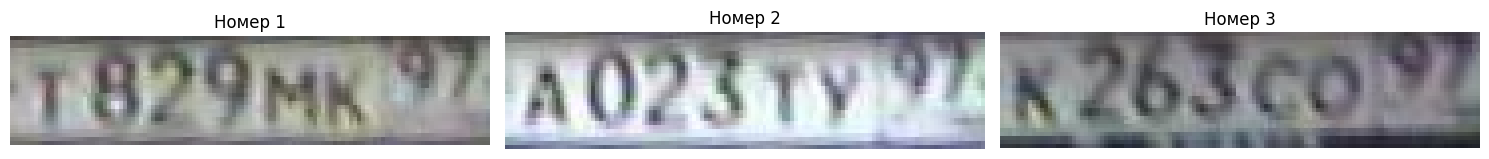

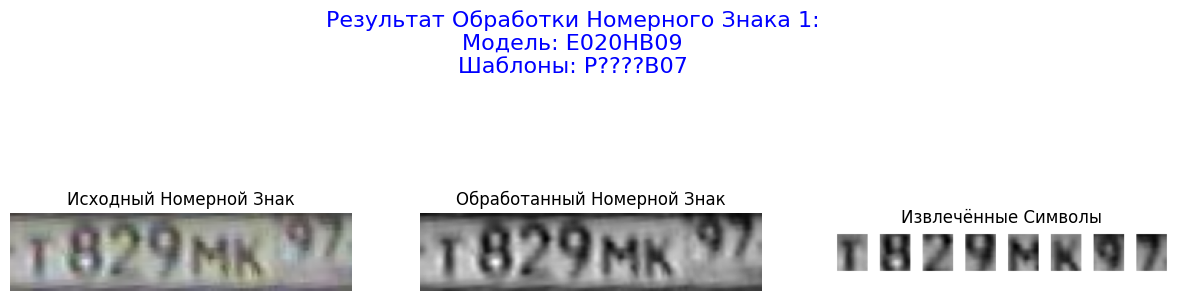

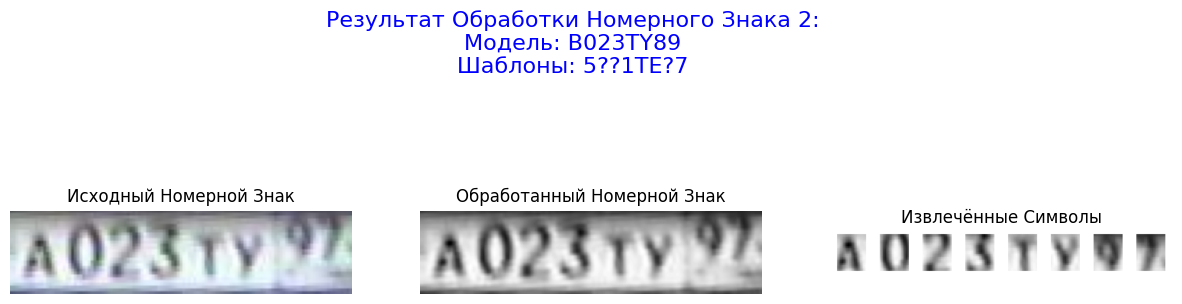

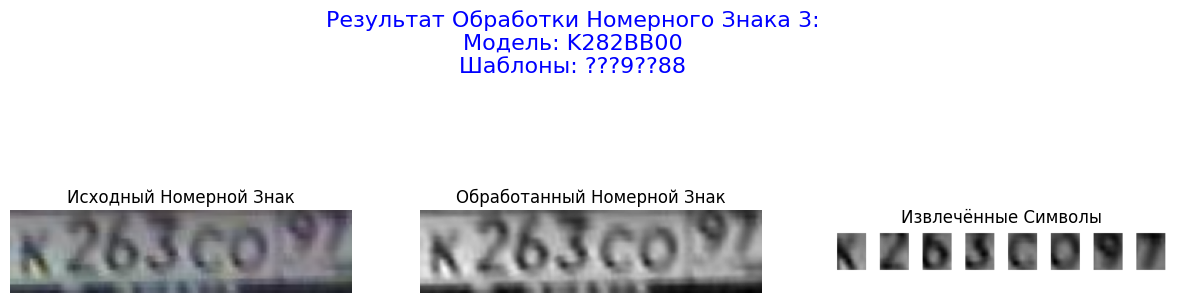

In [14]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
import torch
import torch.nn as nn
from torchvision import transforms

# 1. Функция для упорядочивания точек
def order_points(pts):
    """
    Упорядочивает точки в порядке:
    верхний левый, верхний правый, нижний правый, нижний левый
    """
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] 
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] 
    rect[3] = pts[np.argmax(diff)] 

    return rect

# 2. Функция для перспективного преобразования
def get_transform(image, pts, padding=0.1):
    """
    Применяет перспективное преобразование к области, определенной точками pts в изображении.
    Уменьшает область захвата на заданный процент (padding).
    Возвращает обрезанное и преобразованное изображение номерного знака.
    
    :param image: Исходное изображение
    :param pts: Точки контура номерного знака (4 точки)
    :param padding: Процент уменьшения области захвата (например, 0.1 для 10%)
    """
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    center = np.mean(rect, axis=0)

    vectors = rect - center

    rect_shrinked = rect - vectors * padding

    rect_shrinked[:, 0] = np.clip(rect_shrinked[:, 0], 0, image.shape[1] - 1)
    rect_shrinked[:, 1] = np.clip(rect_shrinked[:, 1], 0, image.shape[0] - 1)

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect_shrinked, dst)

    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def get_transformed_plate(image, bbox, padding=0.1):
    """
    Выполняет перспективное преобразование для извлечения номерного знака из изображения.
    Уменьшает область захвата на заданный процент (padding).
    
    :param image: Исходное изображение
    :param bbox: Координаты ограничивающего прямоугольника (4 точки)
    :param padding: Процент уменьшения области захвата (например, 0.1 для 10%)
    :return: Преобразованное изображение номерного знака
    """
    plate = get_transform(image, bbox, padding)
    return plate

# 4. Функция для изменения размера с сохранением соотношения сторон и добавлением отступов
def resize_with_padding(image, size=28, padding=4, bg_color=255):
    """
    Изменяет размер изображения до заданного размера с сохранением соотношения сторон
    и добавлением отступов.
    
    :param image: Градация серого изображения символа (numpy array).
    :param size: Целевой размер (ширина и высота) итогового изображения.
    :param padding: Количество пикселей для отступов.
    :param bg_color: Цвет фона (0 для чёрного, 255 для белого).
    :return: Изображение размером size x size пикселей.
    """
    # Преобразуем numpy array в PIL Image
    pil_img = Image.fromarray(image)
    
    # Определяем текущие размеры
    w, h = pil_img.size
    
    # Рассчитываем масштабирование
    scale = (size - 2 * padding) / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Изменяем размер с сохранением соотношения сторон
    pil_resized = pil_img.resize((new_w, new_h), Image.LANCZOS)
    
    # Создаём новое изображение с фоном
    new_img = Image.new("L", (size, size), color=bg_color)
    
    # Вычисляем позицию для центрирования
    paste_x = (size - new_w) // 2
    paste_y = (size - new_h) // 2
    
    # Вставляем изменённое изображение на фон
    new_img.paste(pil_resized, (paste_x, paste_y))
    
    # Преобразуем обратно в numpy array
    return np.array(new_img)

# 5. Обновлённые маски
mask_8 = [
    (0.05, 0.25, 0.1, 0.5),  # Символ 1: Буква
    (0.17, 0.25, 0.1, 0.5),  # Символ 2: Цифра
    (0.29, 0.25, 0.1, 0.5),  # Символ 3: Цифра
    (0.41, 0.25, 0.1, 0.5),  # Символ 4: Цифра
    (0.53, 0.25, 0.1, 0.5),  # Символ 5: Буква
    (0.65, 0.25, 0.1, 0.5),  # Символ 6: Буква
    (0.80, 0.05, 0.1, 0.5),  # Символ 7: Региональная цифра 1 (выше и меньше)
    (0.90, 0.05, 0.1, 0.5)   # Символ 8: Региональная цифра 2 (выше и меньше)
]

mask_9 = [
    (0.05, 0.25, 0.1, 0.5),  # Символ 1: Буква
    (0.17, 0.25, 0.1, 0.5),  # Символ 2: Цифра
    (0.29, 0.25, 0.1, 0.5),  # Символ 3: Цифра
    (0.41, 0.25, 0.1, 0.5),  # Символ 4: Цифра
    (0.53, 0.25, 0.1, 0.5),  # Символ 5: Буква
    (0.65, 0.25, 0.1, 0.5),  # Символ 6: Буква
    (0.77, 0.05, 0.1, 0.6),  # Символ 7: Региональная цифра 1
    (0.89, 0.05, 0.1, 0.6),  # Символ 8: Региональная цифра 2
    (1.01, 0.05, 0.1, 0.6)   # Символ 9: Региональная цифра 3
]

# 6. Функция для извлечения символов
def extract_symbols(image, masks):
    """
    Извлекает символы из изображения на основе предоставленных масок.
    
    :param image: Градация серого изображения номерного знака.
    :param masks: Список кортежей с определениями маски как (x_frac, y_frac, w_frac, h_frac).
    :return: Список извлечённых и изменённых по размеру изображений символов.
    """
    img_h, img_w = image.shape
    symbols = []
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        
        # Убедимся, что область находится внутри границ изображения
        x_end = min(x + w, img_w)
        y_end = min(y + h, img_h)
        
        symbol = image[y:y_end, x:x+w]
        if symbol.size == 0:
            # Если область вне границ изображения, пропускаем
            continue
        # Изменяем размер с сохранением соотношения сторон и добавлением отступов
        symbol_resized = resize_with_padding(symbol, size=28, padding=2, bg_color=255)
        symbols.append(symbol_resized)
    return symbols

# 7. Функция для проверки наличия символа
def is_symbol_present(symbol, threshold=250):
    """
    Определяет, присутствует ли символ на изображении на основе средней интенсивности пикселей.
    
    :param symbol: Градация серого изображения символа.
    :param threshold: Порог интенсивности для определения присутствия символа.
    :return: Логическое значение, указывающее на наличие символа.
    """
    return np.mean(symbol) < threshold  # Тёмные символы имеют меньшую среднюю интенсивность

# 8. Основная функция обработки одной пластинки
def process_plate(plate):
    """
    Обрабатывает одно изображение номерного знака для извлечения отдельных символов на основе масок.
    
    :param plate: BGR изображение вырезанного номерного знака.
    :return: Кортеж, содержащий обработанное изображение, список извлечённых символов и ожидаемые типы символов.
    """
    if plate is None:
        return None, [], []
    
    # Преобразование в градации серого
    gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    # Увеличение размера для консистентной обработки
    resized_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img_h, img_w = resized_plate.shape

    # Применение гауссового размытия для снижения шума
    blurred = cv2.GaussianBlur(resized_plate, (3, 3), 0)

    # Извлечение символов с использованием обеих масок
    symbols_8 = extract_symbols(blurred, mask_8)
    symbols_9 = extract_symbols(blurred, mask_9)

    # Определение, какую маску использовать, основываясь на наличии третьей региональной цифры
    if len(symbols_9) == 9 and is_symbol_present(symbols_9[-1]):
        characters = symbols_9
        expected_types = ['letter', 'digit', 'digit', 'digit', 'letter', 'letter', 'digit', 'digit', 'digit']
    else:
        characters = symbols_8
        expected_types = ['letter', 'digit', 'digit', 'digit', 'letter', 'letter', 'digit', 'digit']

    return blurred, characters, expected_types

# 9. Функция для визуализации маски (опционально, для калибровки)
def visualize_mask(image, masks):
    """
    Отображает области маски на изображении для визуальной проверки.
    
    :param image: Градация серого изображения номерного знака.
    :param masks: Список кортежей с определениями маски.
    """
    img_h, img_w = image.shape
    img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 10. Код для сбора processed_plates
def gather_processed_plates(image_paths, padding=0.1):
    """
    Загружает изображения, обнаруживает номерные знаки и извлекает их.
    
    :param image_paths: Список путей к изображениям.
    :param padding: Процент уменьшения области захвата (например, 0.1 для 10%)
    :return: Список преобразованных изображений номерных знаков.
    """
    processed_plates = []
    
    for img_path in image_paths:
        image = cv2.imread(img_path)
        
        if image is None:
            print(f"Не удалось загрузить изображение по пути: {img_path}")
            processed_plates.append(None)
            continue

        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        ret, thresh = cv2.threshold(img_gray, 100, 200, cv2.THRESH_TOZERO_INV)
        
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        plate_found = False 

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            aspectRatio = float(w) / h

            if aspectRatio >= 3 and area > 600:
                approx = cv2.approxPolyDP(cnt, 0.05 * cv2.arcLength(cnt, True), True)
                
                if len(approx) <= 4 and x > 15:
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect)
                    box = np.intp(box)

                    plate = get_transformed_plate(image, box, padding=padding) 

                    processed_plates.append(plate)
                    plate_found = True
                    break 

        if not plate_found:
            print(f"Номерной знак не найден на изображении: {img_path}")
            processed_plates.append(None)
    
    return processed_plates

# 11. Функция для распознавания символов с учётом ожидаемого типа
def recognize_plate_number(characters, expected_types, model, transform, CLASSES, letter_classes, digit_classes, templates, device="cpu"):
    """
    Распознает номерной знак, учитывая ожидаемый тип каждого символа, используя модель и шаблоны.

    :param characters: Список изображений символов.
    :param expected_types: Список ожидаемых типов символов ('letter' или 'digit').
    :param model: Обученная модель для распознавания символов.
    :param transform: Преобразования для подготовки изображений перед подачей в модель.
    :param CLASSES: Строка с классами.
    :param letter_classes: Список букв.
    :param digit_classes: Список цифр.
    :param templates: Словарь с шаблонными изображениями.
    :param device: Устройство для вычислений ('cpu' или 'cuda').
    :return: Кортеж из двух строк: распознанный номер моделью и распознанный номер шаблонами.
    """
    recognized_number_model = ""
    recognized_number_template = ""
    for idx, (symbol_img, expected_type) in enumerate(zip(characters, expected_types)):
        # --- Модельное распознавание ---
        # Преобразование изображения символа в формат, подходящий для модели
        pil_img = Image.fromarray(symbol_img)
        input_tensor = transform(pil_img).unsqueeze(0).to(device)  # Добавляем размерность батча

        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

        if expected_type == 'letter':
            valid_indices = [i for i, c in enumerate(CLASSES) if c in letter_classes]
        elif expected_type == 'digit':
            valid_indices = [i for i, c in enumerate(CLASSES) if c in digit_classes]
        else:
            valid_indices = list(range(len(CLASSES)))  # Если тип не определен, рассматриваем все классы

        if not valid_indices:
            recognized_char_model = '?'
        else:
            # Выбираем индекс с максимальной вероятностью среди допустимых
            max_prob_idx = valid_indices[np.argmax(probabilities[valid_indices])]
            recognized_char_model = CLASSES[max_prob_idx]

        recognized_number_model += recognized_char_model

        # --- Шаблонное сопоставление ---
        recognized_char_template = pattern_match_symbol(symbol_img, templates)
        recognized_number_template += recognized_char_template

    return recognized_number_model, recognized_number_template

# 12. Загрузка и подготовка модели
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Увеличиваем количество фильтров
            nn.LeakyReLU(negative_slope=0.1),  # Используем LeakyReLU вместо ReLU
            nn.BatchNorm2d(32),  # Нормализация
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),  # Используем ELU вместо ReLU
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),  # Используем SiLU (Swish) вместо ReLU
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.GELU(),  # Используем GELU для полносвязного слоя
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
    
# Определение классов и групп
CLASSES = "ABEKMHOPCTYX0123456789"
NUM_CLASSES = len(CLASSES)
DEVICE = "cpu" 
letter_classes = list("ABEKMHOPCTYX")
digit_classes = list("0123456789")

# Загрузка модели
model = SimpleCNN(NUM_CLASSES).to(DEVICE)
model_path = "best_model.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Файл модели '{model_path}' не найден.")
model.load_state_dict(torch.load(model_path, map_location=DEVICE)) 
model.eval()

# Определение преобразований
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 13. Функция для загрузки шаблонов
def load_templates(template_dir, classes, transform):
    """
    Загрузить и предварительно обработать шаблонные изображения из указанной директории.

    :param template_dir: Путь к директории с шаблонными изображениями.
    :param classes: Строка с классами.
    :param transform: Преобразования для подготовки изображений.
    :return: Словарь, сопоставляющий класс с изображением шаблона.
    """
    templates = {}
    for cls in classes:
        template_path = os.path.join(template_dir, f"{cls}.png")
        if not os.path.exists(template_path):
            print(f"Шаблон для класса '{cls}' не найден по пути: {template_path}")
            continue
        template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        if template_img is None:
            print(f"Не удалось загрузить шаблонное изображение для класса '{cls}' из {template_path}")
            continue
        # Предварительная обработка: изменение размера и нормализация
        template_resized = resize_with_padding(template_img, size=28, padding=2, bg_color=255)
        templates[cls] = template_resized
    return templates

# 14. Функция для шаблонного сопоставления
def pattern_match_symbol(symbol_img, templates):
    """
    Выполняет шаблонное сопоставление для распознавания символа.

    :param symbol_img: Градация серого изображения символа (numpy array).
    :param templates: Словарь с шаблонными изображениями.
    :return: Распознанный класс символа или '?'.
    """
    best_match = '?'
    best_score = -1  # Инициализируем с очень низкого значения
    for cls, template in templates.items():
        # Убедимся, что оба изображения в формате uint8
        symbol = symbol_img.astype(np.uint8)
        template = template.astype(np.uint8)
        # Применяем пороговую обработку, если необходимо
        # Для шаблонного сопоставления оба изображения должны быть однотонными
        # Например, бинаризация
        _, symbol_thresh = cv2.threshold(symbol, 128, 255, cv2.THRESH_BINARY_INV)
        _, template_thresh = cv2.threshold(template, 128, 255, cv2.THRESH_BINARY_INV)
        # Выполняем шаблонное сопоставление
        res = cv2.matchTemplate(symbol_thresh, template_thresh, cv2.TM_CCOEFF_NORMED)
        score = res[0][0]
        if score > best_score:
            best_score = score
            best_match = cls
    # Определяем порог для принятия совпадения
    threshold = 0.3  # Этот параметр можно настроить
    if best_score < threshold:
        return '?'
    return best_match

# 15. Пример использования
if __name__ == "__main__":
    # Пути к изображениям
    images = ['img/1.jpg', 'img/2.jpg', 'img/3.jpg'] # Замените на ваши пути

    # Путь к директории с шаблонами
    template_dir = 'templates'

    # Загрузка шаблонов
    templates = load_templates(template_dir, CLASSES, transform)

    # Сборка processed_plates
    processed_plates = gather_processed_plates(images, padding=0.1)

    num_plates = len(processed_plates)

    cols = min(num_plates, 3)
    rows = (num_plates + cols - 1) // cols 

    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    if num_plates == 1:
        axs = [axs] 
    else:
        axs = axs.flatten()

    for i, plate in enumerate(processed_plates):
        ax = axs[i]
        if plate is not None:
            if len(plate.shape) == 3:
                plate_rgb = cv2.cvtColor(plate, cv2.COLOR_BGR2RGB)
                ax.imshow(plate_rgb)
            else:
                ax.imshow(plate, cmap='gray')
        else:
            ax.text(0.5, 0.5, 'Номер не найден', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        
        ax.set_title(f'Номер {i+1}')
        ax.axis('off')
    
    # Удаление лишних субплотов, если они есть
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

    # Обработка и отображение извлечённых символов
    for plate_index, plate in enumerate(processed_plates):
        # Проверка корректности загрузки изображения
        if plate is None:
            print(f"Номерной знак {plate_index + 1} не обработан.")
            continue

        # Обработка номерного знака для извлечения символов
        processed_plate, characters, expected_types = process_plate(plate)

        # Распознавание номера
        recognized_number_model, recognized_number_template = recognize_plate_number(
            characters, 
            expected_types, 
            model, 
            transform, 
            CLASSES, 
            letter_classes, 
            digit_classes, 
            templates, 
            device=DEVICE
        )

        # Отображение результатов
        plt.figure(figsize=(15, 5))

        # Исходный номерной знак
        plt.subplot(1, 3, 1)
        plt.title("Исходный Номерной Знак")
        if len(plate.shape) == 3:
            plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(plate, cmap='gray')
        plt.axis('off')

        # Обработанное изображение (градации серого и размытие)
        plt.subplot(1, 3, 2)
        plt.title("Обработанный Номерной Знак")
        plt.imshow(processed_plate, cmap='gray')
        plt.axis('off')

        # Извлечённые символы
        plt.subplot(1, 3, 3)
        plt.title("Извлечённые Символы")
        if characters:
            # Располагаем символы в горизонтальном ряду
            symbols_grid = np.hstack(characters)
            plt.imshow(symbols_grid, cmap='gray')
        else:
            plt.text(0.5, 0.5, 'Символы не обнаружены', ha='center', va='center', fontsize=12)
        plt.axis('off')

        # Добавление заголовка с распознанным номером обоими методами
        plt.suptitle(f"Результат Обработки Номерного Знака {plate_index + 1}:\n"
                     f"Модель: {recognized_number_model}\n"
                     f"Шаблоны: {recognized_number_template}", fontsize=16, color='blue')

        plt.show()
